In [32]:
!pip install gower

In [34]:
import pandas
import numpy
import gower
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn
import matplotlib.pyplot as plt




my_data_frame = pandas.read_csv('/Academic-Data.csv', header = 0) # Your path may differ
print(my_data_frame)

      Marital status  Application mode  Application order  Course  \
0                  1                17                  5     171   
1                  1                15                  1    9254   
2                  1                 1                  5    9070   
3                  1                17                  2    9773   
4                  2                39                  1    8014   
...              ...               ...                ...     ...   
4419               1                 1                  6    9773   
4420               1                 1                  2    9773   
4421               1                 1                  1    9500   
4422               1                 1                  1    9147   
4423               1                10                  1    9773   

      Daytime/evening attendance  Previous qualification  \
0                              1                       1   
1                              1                   

In [35]:
# Seperating the labels from the other attributes and paring down the data to 1000 records
labels = my_data_frame.iloc[:1000, -1]
data = my_data_frame.iloc[:1000, :-1]


# Specifying datatypes of the different attributes
categorical_attributes = ["Marital status", "Application mode", "Course", "Daytime/evening attendance", "Previous qualification", "Nacionality", "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", "Displaced", "Educational special needs", "Debtor", "Tuition fees up to date", "Gender", "Scholarship holder", "International"]
numerical_attributes = ["Application order", "Previous qualification (grade)", "Admission grade", "Age at enrollment", "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)", "Curricular units 1st sem (evaluations)", "Curricular units 1st sem (approved)", "Curricular units 1st sem (grade)", "Curricular units 1st sem (without evaluations)", "Curricular units 2nd sem (credited)", "Curricular units 2nd sem (enrolled)", "Curricular units 2nd sem (evaluations)", "Unemployment rate", "Inflation rate", "GDP"]


# This step applies Min-Max scaling to only the numerical attributes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_attributes),  # Apply MinMaxScaler to numerical columns
        ('cat', 'passthrough', categorical_attributes)  # Leave categorical columns unchanged
    ])


processed_data_array = preprocessor.fit_transform(data)
processed_dataframe = pandas.DataFrame(processed_data_array, columns=numerical_attributes + categorical_attributes) # The preprocessor returns a numpy array so we need to convert it back into a dataframe so we can keep track of datatype info (categorical vs. numerical)


# Adding the type information to the dataframe (optional step but allows us to get the view of the data below)
for column in categorical_attributes:
  processed_dataframe[column] = processed_dataframe[column].astype('category')

for column in numerical_attributes:
  processed_dataframe[column] = processed_dataframe[column].astype('float')


# Dropping attributes that lead to misleading distance calculations
columns_to_omit = ["Unemployment rate", "Inflation rate", "GDP", "Application mode", "Course", "Previous qualification", "Mother's qualification", "Father's qualification", "Mother's occupation","Father's occupation"]
processed_dataframe.drop(columns_to_omit, axis=1, inplace=True)

# As you can see the data is now scaled and organized by data type which will come in handy later
print(processed_dataframe.dtypes)

Application order                                  float64
Previous qualification (grade)                     float64
Admission grade                                    float64
Age at enrollment                                  float64
Curricular units 1st sem (credited)                float64
Curricular units 1st sem (enrolled)                float64
Curricular units 1st sem (evaluations)             float64
Curricular units 1st sem (approved)                float64
Curricular units 1st sem (grade)                   float64
Curricular units 1st sem (without evaluations)     float64
Curricular units 2nd sem (credited)                float64
Curricular units 2nd sem (enrolled)                float64
Curricular units 2nd sem (evaluations)             float64
Marital status                                    category
Daytime/evening attendance                        category
Nacionality                                       category
Displaced                                         catego

In [36]:
# Train-test split (80% train - 20% test)
training_data, testing_data, training_labels, testing_labels = train_test_split(processed_dataframe,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)

In [37]:
# Need to wrap gower_matrix, this allows it to be used as the distance metric for KNeighborsClassifier
def my_gower_metric(X1, X2):

    # Need to reshape inputs so they are 2-dimensional
    X1 = X1.reshape(1, -1)
    X2 = X2.reshape(1, -1)

    # Concatenating the records
    input = numpy.vstack((X1, X2))

    # This boolean mask specifies which columns contain categorical attributes
    # The way this is structured depends on the way the data was processed in the previous steps
    # True for categorical column, False for numerical
    bool_mask = [True if i > 12 else False for i in range(input.shape[1])]

    return gower.gower_matrix(input, cat_features = bool_mask)[0,1]


# Applying KNN
model = KNeighborsClassifier(n_neighbors=5, metric = my_gower_metric)
model.fit(training_data, training_labels)
predicted_labels = model.predict(testing_data)

Accuracy: 0.705
Precision: 0.6212885154061625
Recall: 0.5734925401592069
F1 Score: 0.5758971604836267

Confusion Matrix:


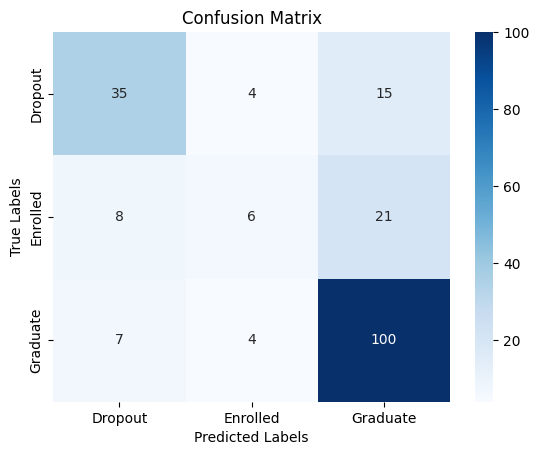

In [40]:
# Metrics
accuracy = accuracy_score(testing_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(testing_labels, predicted_labels, average='macro')
my_confusion_matrix = confusion_matrix(testing_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nConfusion Matrix:")

# Confusion matrix
seaborn.heatmap(my_confusion_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Dropout', 'Enrolled', 'Graduate'],
            yticklabels=['Dropout', 'Enrolled', 'Graduate'])


plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")


plt.show()